In [1]:
#==================================================
#                import package
#=================================================
import math
from pynq import Overlay
from PIL import Image as PIL_Image
from PIL import ImageDraw as PIL_ImageDraw
from PIL import ImageFont
import matplotlib.pyplot as plt
import numpy as np
import math
from pynq import MMIO
from pynq import Xlnk
import time
import ctypes

In [2]:
#image path 
ORIG_IMG_PATH   = 'people_back.jpg'

In [3]:

#==================================================
#                Load overlay  and IP
#=================================================
overlay = Overlay("YOLO.bit")
overlay?

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


In [4]:

xlnk = Xlnk()   
xlnk.xlnk_reset()

In [5]:
#==================================================
#            allocated the memory  inbuff
#=================================================

weight_base_buffer = xlnk.cma_array(shape=(25470896,), dtype=np.uint32)
print("100M",weight_base_buffer.physical_address)
WEIGHT_BASE = weight_base_buffer.physical_address

bate_base_buffer = xlnk.cma_array(shape=(5381,), dtype=np.uint32)
print("32k",bate_base_buffer.physical_address)
BETA_BASE=bate_base_buffer.physical_address


img_base_buffer = xlnk.cma_array(shape=(4194304,), dtype=np.int32)
print("16M",img_base_buffer.physical_address)
IMG_MEM = img_base_buffer.physical_address



100M 403701760
32k 402948096
16M 506462208


In [6]:
#===============================================
#   yolov2 weight and bais copyto memory
#==============================================
# params_wight = np.fromfile("yolov2_w_reorg_bn_ap16_short16.bin", dtype=np.uint32)
params_wight = np.fromfile("yolov2_w_reorg_bn_ap16_short16.bin", dtype=np.uint32)
np.copyto(weight_base_buffer, params_wight)
print("yolov2_weight copy ok\n")

# params_bais = np.fromfile("yolov2_b_ap16_short16.bin", dtype=np.uint32)
params_bais = np.fromfile("yolov2_b_ap16_short16.bin", dtype=np.uint32)
np.copyto(bate_base_buffer, params_bais)
print("yolov2_bais copy ok\n")



yolov2_weight copy ok

yolov2_bais copy ok



In [7]:
#===============================================
#           yolov2 net_work data
#==============================================

weight_offset = [864, 18432, 73728, 8192, 73728,
		294912, 32768, 294912, 1179648, 131072, 1179648, 131072,
		1179648, 4718592, 524288, 4718592, 524288, 4718592, 9437184,
		9437184, 32768, 11796480, 435200, 0, 0, 0, 0, 0, 0, 0, 0, 0]
beta_offset = [32, 64, 128, 64, 128, 256, 128, 256, 512, 256, 512, 256, 512, 1024,
		512, 1024, 512, 1024, 1024, 1024, 64, 1024, 425, 0, 0, 0, 0, 0, 0, 0, 0, 0]
inputQ  = [14,10,10,10,10,11,11,10,11,11,10,10,10,10,11, 9,11,10, 9,11,10,10,11,10]
weightQ = [ 10,15,15,13,15,15,14,15,15,14,15,14,15,15,14,15,14,14,15,15,15,15,14 ]
betaQ = [11,12,11,12,12,12,12,12,12,13,12,12,13,13,13,12,12,12,15,13,14,13,13 ]

net_layers_outputs = [5537792,1384448,2768896,692224,1384448,692224,1384448,346112,
									692224,346112,692224,173056,346112,173056,346112,173056,
									346112,86528,173056,86528,173056,86528,173056,173056,
									173056,346112,43264,43264,216320,173056,71825,71825]

layertype = [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 3, 0, 0, 4]
layersize = [3, 2, 3, 2, 3, 1, 3, 2, 3, 1, 3, 2, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 3, 3, 0, 1, 0, 0, 3, 1, 0]
layerstride = [1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0]
layerbatch_normalize = [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
layeractivation = [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
layern= [32, 0, 64, 0, 128, 64, 128, 0, 256, 128, 256, 0, 512, 256, 512, 256, 512, 0, 1024, 512, 1024, 512, 1024, 1024, 1024, 1, 64, 0, 2, 1024, 425, 5]
layerw = [416, 416, 208, 208, 104, 104, 104, 104, 52, 52, 52, 52, 26, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 0, 26, 26, 0, 13, 13, 13]
layerh= [416, 416, 208, 208, 104, 104, 104, 104, 52, 52, 52, 52, 26, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 0, 26, 26, 0, 13, 13, 13]
layerc = [3, 32, 32, 64, 64, 128, 64, 128, 128, 256, 128, 256, 256, 512, 256, 512, 256, 512, 512, 1024, 512, 1024, 512, 1024, 1024, 0, 512, 64, 0, 1280, 1024, 425]
layerout_w = [416, 208, 208, 104, 104, 104, 104, 52, 52, 52, 52, 26, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 13, 26, 26, 13, 13, 13, 13, 13]
layerout_h = [416, 208, 208, 104, 104, 104, 104, 52, 52, 52, 52, 26, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 13, 26, 26, 13, 13, 13, 13, 13]
layerout_c = [32, 32, 64, 64, 128, 64, 128, 128, 256, 128, 256, 256, 512, 256, 512, 256, 512, 512, 1024, 512, 1024, 512, 1024, 1024, 1024, 512, 64, 256, 1280, 1024, 425, 425]
layerpad = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0,0,1,0,0]
layerbias = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

classes = 80
batch = 1
coords=4
background = 0
softmax =1

S=2
K=3 
Tn=2
Tm=32
Tr=26
Tc=26

OnChipIB_Width=((Tc-1)*S+K)
OnChipIB_Height=((Tr-1)*S+K)
ALPHA_BETA_MAX_NUM=1024

MEM_BASE = IMG_MEM
MEM_LEN = 416*416*32*2+208*208*32*2
Memory_top = MEM_BASE
Memory_bottom = MEM_BASE + MEM_LEN
    
ROUTE16_LEN =26*26*512*4//2
CONV27_LEN =13*13*256*4//2
CONV24_LEN =13*13*1024*4//2

LastLayerOutputPara = pow(2.0,-inputQ[23])

in_ptr  = np.zeros(32)
out_ptr = np.zeros(32)
for x in range(0,18):
        if x%2 == 0:
            in_ptr[x] = Memory_top
            out_ptr[x] =  Memory_bottom - net_layers_outputs[x]*4//2
        else:
            in_ptr[x] = out_ptr[x-1]
            out_ptr[x] = Memory_top
            

for x in range(18,25):
    if x%2 == 0:
            in_ptr[x] = Memory_top
            out_ptr[x] = Memory_bottom - ROUTE16_LEN - net_layers_outputs[x]*4//2
    
    else:
            in_ptr[x] = out_ptr[x-1];
            out_ptr[x] = Memory_top;
        
in_ptr[26] = Memory_bottom - ROUTE16_LEN
out_ptr[26] = Memory_top  

in_ptr[27] = Memory_top
out_ptr[27] = Memory_bottom - ROUTE16_LEN - CONV24_LEN - CONV27_LEN
    
in_ptr[29] = out_ptr[27]
out_ptr[29] = Memory_top

in_ptr[30] = Memory_top
out_ptr[30] = Memory_bottom - (net_layers_outputs[30] + 1024*7)*4//2

if(out_ptr[30]%(4*1024)!=0):
    out_ptr[30] = (out_ptr[30]//(4*1024)-1)*(4*1024)
in_ptr[31] = out_ptr[30]
    

In [8]:

#===============================================
#                  yolov2 hw Ex
#==============================================

#IP_base_address
IP_BASE_ADDRESS    =  0x43C00000
ADDRESS_RANGE      = 4000
#XYOLO2_FPGA_CTRL_BUS_ADDR 
XYOLO2_FPGA_CTRL_BUS_ADDR_AP_CTRL            =0x00
XYOLO2_FPGA_CTRL_BUS_ADDR_GIE                =0x04
XYOLO2_FPGA_CTRL_BUS_ADDR_IER                =0x08
XYOLO2_FPGA_CTRL_BUS_ADDR_ISR                =0x0c
XYOLO2_FPGA_CTRL_BUS_ADDR_INPUT_R_DATA       =0x10
XYOLO2_FPGA_CTRL_BUS_ADDR_OUTPUT_R_DATA      =0x18
XYOLO2_FPGA_CTRL_BUS_ADDR_WEIGHT_DATA        =0x20
XYOLO2_FPGA_CTRL_BUS_ADDR_BETA_DATA          =0x28
XYOLO2_FPGA_CTRL_BUS_ADDR_INFM_NUM_DATA      =0x30
XYOLO2_FPGA_CTRL_BUS_ADDR_OUTFM_NUM_DATA     =0x38
XYOLO2_FPGA_CTRL_BUS_ADDR_KERNEL_SIZE_DATA   =0x40
XYOLO2_FPGA_CTRL_BUS_ADDR_KERNEL_STRIDE_DATA =0x48
XYOLO2_FPGA_CTRL_BUS_ADDR_INPUT_W_DATA       =0x50
XYOLO2_FPGA_CTRL_BUS_ADDR_INPUT_H_DATA       =0x58
XYOLO2_FPGA_CTRL_BUS_ADDR_PADDING_DATA       =0x60
XYOLO2_FPGA_CTRL_BUS_ADDR_ISNL_DATA          =0x68
XYOLO2_FPGA_CTRL_BUS_ADDR_ISBN_DATA          =0x70
XYOLO2_FPGA_CTRL_BUS_ADDR_TM_DATA            =0x78
XYOLO2_FPGA_CTRL_BUS_ADDR_TN_DATA            =0x80
XYOLO2_FPGA_CTRL_BUS_ADDR_TR_DATA            =0x88
XYOLO2_FPGA_CTRL_BUS_ADDR_TC_DATA            =0x90
XYOLO2_FPGA_CTRL_BUS_ADDR_MLOOPS_DATA        =0x98
XYOLO2_FPGA_CTRL_BUS_ADDR_NLOOPS_DATA        =0xa0
XYOLO2_FPGA_CTRL_BUS_ADDR_RLOOPS_DATA        =0xa8
XYOLO2_FPGA_CTRL_BUS_ADDR_CLOOPS_DATA        =0xb0
XYOLO2_FPGA_CTRL_BUS_ADDR_LAYERTYPE_DATA     =0xb8
XYOLO2_FPGA_CTRL_BUS_ADDR_INPUTQ_DATA        =0xc0
XYOLO2_FPGA_CTRL_BUS_ADDR_OUTPUTQ_DATA       =0xc8
XYOLO2_FPGA_CTRL_BUS_ADDR_WEIGHTQ_DATA       =0xd0
XYOLO2_FPGA_CTRL_BUS_ADDR_BETAQ_DATA         =0xd8

#XYOLO2_FPGA_CTRL_BUS_ADDR Write data

def YOLO__Init_EX(In_Address,Out_Address,Weight_offset,Beta_offset,InFM_num,OutFM_num,
                 Kernel_size,Kernel_stride,
                 Input_w,Input_h,Padding,IsNL,IsBN,
                 TM,TN,TR,TC,
                 mLoops,nLoops,rLoops,cLoops,LayerType,
                 InputQ,OutputQ,WeightQ,BetaQ,WEIGHT_BASE,BETA_BASE):
   
    # mapping memory
    mmio = MMIO(IP_BASE_ADDRESS,ADDRESS_RANGE)
    
    
    while True:
        ap_idle =  (mmio.read(XYOLO2_FPGA_CTRL_BUS_ADDR_AP_CTRL)>>2)&0x01
        if(ap_idle):
            break
            
            
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_INPUT_R_DATA,  In_Address)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_OUTPUT_R_DATA, Out_Address)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_WEIGHT_DATA,   WEIGHT_BASE+Weight_offset*4)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_BETA_DATA,     BETA_BASE+Beta_offset*4)

    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_INFM_NUM_DATA, InFM_num)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_OUTFM_NUM_DATA, OutFM_num)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_KERNEL_SIZE_DATA, Kernel_size)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_KERNEL_STRIDE_DATA, Kernel_stride)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_INPUT_W_DATA, Input_w)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_INPUT_H_DATA, Input_h)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_PADDING_DATA, Padding)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_ISNL_DATA, IsNL)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_ISBN_DATA, IsBN)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_TM_DATA, TM)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_TN_DATA, TN)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_TR_DATA, TR)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_TC_DATA, TC)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_MLOOPS_DATA, mLoops)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_NLOOPS_DATA, nLoops)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_RLOOPS_DATA, rLoops)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_CLOOPS_DATA, cLoops)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_LAYERTYPE_DATA, LayerType)

    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_INPUTQ_DATA, InputQ)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_OUTPUTQ_DATA, OutputQ)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_WEIGHTQ_DATA, WeightQ)
#   mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_ALPHAQ_DATA, AlphaQ)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_BETAQ_DATA, BetaQ)
    

    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_GIE,0)
    mmio.write(XYOLO2_FPGA_CTRL_BUS_ADDR_AP_CTRL,1)
    while True:
        ap_done =  (mmio.read(XYOLO2_FPGA_CTRL_BUS_ADDR_AP_CTRL)>>1)&0x01
        if(ap_done):
            break

In [9]:
#============================================
#			read image and resize 
#============================================
def load_image():
        orig_img_path = (ORIG_IMG_PATH)

        try:
            img = PIL_Image.open(orig_img_path)
            print("Open pictrue success!")
        except IOError:
            print("fail to load image!")
        print("pictrue size:",img.size)
        print("pictrue mode:",img.mode)  
        return img
    
def letterbox_image(img,w,h):
        if((float)(w/img_w))<((float)(h/img_h)):
            new_w = w
            new_h = (img_h*w)//img_w
        else:
            new_w = (img_w*h)//img_h
            new_h = h
        img_resized = img.resize((new_w,new_h),PIL_Image.BILINEAR)

        boxed = PIL_Image.new('RGB',(w,h),(127,127,127))
        box1 = (0,0,new_w,new_h)
        boxed.paste(img_resized.crop(box1),((w-new_w)//2,(h-new_h)//2))
        
        return boxed
def image_to_array_1dim(img,w,h):
    
        img_r,img_g,img_b = img.split()


        image_array_r = np.array(img_r,dtype='float32')/255
        image_array_g = np.array(img_g,dtype='float32')/255
        image_array_b = np.array(img_b,dtype= 'float32')/255

        image_array_r = image_array_r.reshape(w*h,)
        image_array_g = image_array_g.reshape(w*h,)
        image_array_b = image_array_b.reshape(w*h,)

        img_array_3 = [image_array_r,image_array_g,image_array_b]
        img_array_3 = np.array(img_array_3)
        img_array_3 = img_array_3.reshape(3*w*h,)
        return img_array_3

def float32_int(img_array_3_416_416):
        current_in = np.array(img_array_3_416_416[::2]*(math.pow(2.0,14)),dtype='uint16')
        next_in = np.array(img_array_3_416_416[1::2]*(math.pow(2.0,14)),dtype= 'uint16') 
        input_tmp_img = next_in*65536 + current_in
        input_tmp_img.dtype
        return input_tmp_img   


In [10]:

#==============================================
#                yolov2  Ex  FPGA
#==============================================


def yolo_fpga(img_base_buffer,region_buff):
         
    TR=0
    TC=0
    TM=0
    TN=0
    offset_index=0
    woffset = 0
    boffset = 0

    woffset = 0
    boffset = 0
    
    
    
    OUTPUT = np.zeros((36504,), dtype=np.int32)
    current_p = np.zeros((36504,), dtype=np.int16)
    next_p = np.zeros((36504,), dtype=np.int16)
    output_p = np.zeros((73008,), dtype=np.int16)
    region_buff_temp = np.zeros((73008,), dtype=np.float32)
    LastLayerOutputPara = math.pow(2.0,-inputQ[23])

    for i in range(0,32):
       
        if layertype[i] == 0:
            print(i,"conv")
            output_w = (layerw[i] - layersize[i] + 2*layerpad[i])//layerstride[i] + 1
            output_h = (layerh[i] - layersize[i] + 2*layerpad[i])//layerstride[i] + 1

            TR = min(((OnChipIB_Height-layersize[i])//layerstride[i]+1),Tr)                #keep Kernel_stride>=1
            TR = min(output_h,TR)
            TC = min(((OnChipIB_Width-layersize[i])//layerstride[i]+1),Tc)
            TC = min(output_w,TC)
            TM = min(layern[i],Tm)
            TN = min(layerc[i],Tn)

            rLoops =int(math.ceil(float(output_h)/TR))
            cLoops =int(math.ceil(float(output_w)/TC))
            mLoops =int(math.ceil(float(layern[i])/TM))
            nLoops =int(math.ceil(float(layerc[i])/TN))

    
            YOLO__Init_EX(int(in_ptr[i]),int(out_ptr[i]),woffset//2,boffset//2,
                layerc[i],layern[i],layersize[i],
                layerstride[i],layerw[i],layerh[i],layerpad[i],layeractivation[i],layerbatch_normalize[i],
                TM,TN,TR,TC,
                mLoops,nLoops,rLoops,cLoops,0,
                inputQ[offset_index],inputQ[offset_index+1],weightQ[offset_index],betaQ[offset_index],
                WEIGHT_BASE,BETA_BASE)


    
            woffset += weight_offset[offset_index]
            boffset += beta_offset[offset_index]  
            offset_index = offset_index+1

        elif layertype[i] == 1:
            print(i,"maxpool")
            output_w = (layerw[i] - layersize[i])//layerstride[i] + 1 
            output_h = (layerh[i] - layersize[i])//layerstride[i] + 1  

            TR = min(((OnChipIB_Height-layersize[i])//layerstride[i]+1),Tr)  #//keep Kernel_stride>=1
            TR = min(output_h,TR)
            TC = min(((OnChipIB_Width-layersize[i])//layerstride[i]+1),Tc)
            TC = min(output_w,TC)
            TM = min(Tm,Tn)
            TM = min(layerc[i],TM)

            rLoops = int(math.ceil(float(output_h)/TR))
            cLoops = int(math.ceil(float(output_w)/TC))
            mLoops = int(math.ceil(float(layerc[i])/TM))



            YOLO__Init_EX(int(in_ptr[i]),int(out_ptr[i]),0,0,layerc[i],layerc[i],
                        layersize[i],layerstride[i],layerw[i],layerh[i],0,0,0,TM,0,TR,TC,mLoops,0,rLoops,cLoops,1,
                        inputQ[offset_index],inputQ[offset_index],0,0,
                        WEIGHT_BASE,BETA_BASE)

        elif layertype[i] == 2:
            print(i,"reorg")
            TR = min(((OnChipIB_Height-layerstride[i])//layerstride[i]+1),Tr)      #//keep Kernel_stride>=1
            TC = min(((OnChipIB_Width-layerstride[i])//layerstride[i]+1),Tc)

            TM = 4;
            output_w = 26;
            output_h = 26*16;
            TR = min(output_h,TR)
            TC = min(output_w,TC)
            rLoops = int(math.ceil(float(output_h)/TR))
            cLoops = int(math.ceil(float(output_w)/TC))
            mLoops = 1


            YOLO__Init_EX(int(in_ptr[i]),int(out_ptr[i]),0,0,1,4,
            layerstride[i],layerstride[i],52,52*16,0,0,0,TM,0,TR,TC,mLoops,0,rLoops,cLoops,2,
            inputQ[offset_index],inputQ[offset_index],0,0,
            WEIGHT_BASE,BETA_BASE)
        elif layertype[i] == 3:
            print(i,"route")
        elif layertype[i] == 4:
            print(i,"region")
            address_start = int((in_ptr[i] - MEM_BASE)//4)
            address_end   = int(address_start +13*13*432//2) 
            OUTPUT = img_base_buffer[address_start:address_end].copy()           
            current_p = OUTPUT%65536
            next_p    = OUTPUT//65536
            output_p[::2]  = current_p
            output_p[1::2] =  next_p 
            region_buff_temp = output_p*LastLayerOutputPara 
            np.copyto(region_buff,region_buff_temp)
    print("FPGA_Accelerate_Completed!!")

In [11]:
#============================================
#			Struct detection
#============================================
class box:
    def __init__(self):
            self.x = float()
            self.y = float()
            self.w = float()
            self.h = float()

class detection:
    def __init__(self):
            self.bbox = box() 
            self.classes = int()
            self.prob = []
            self.mask = []
            self.objectness = float()
            self.sort_class = int()

def entry_index(outputs,w,h,batch,location,entry):
            n  =   location //(w*h)    
            loc = location % (w*h)
            return batch*outputs + n*w*h*(4+classes+1) + entry*w*h + loc


def get_region_box(x,biases,n,index,i,j,w,h,stride):

            b=box()
            b.x = (i + x[index + 0*stride]) / w
            b.y = (j + x[index + 1*stride]) / h
            b.w = math.exp(x[index + 2*stride]) * biases[2*n]   / w
            b.h = math.exp(x[index + 3*stride]) * biases[2*n+1] / h
            return b


def correct_region_boxes(n,w,h,netw,neth,dets):

            new_w=0
            new_h=0
    
            if ((float(netw)/w) < (float(neth)/h)):
                new_w = netw;
                new_h = (h * netw)//w
            else:
                new_h = neth
                new_w = (w * neth)//h

            for i in range(0,n):
                b = dets[i].bbox
                b.x =  (b.x - (netw - new_w)/2/netw) /  (float(new_w)/netw)
                b.y =  (b.y - (neth - new_h)/2/neth) /  (float(new_h)/neth)

                b.w = b.w *float(netw)/new_w
                b.h =  b.h *float(neth)/new_h
                
                relative  = 1 
                nrelative = 0
                if(nrelative):
                    b.x *= w
                    b.w *= w
                    b.y *= h
                    b.h *= h

                dets[i].bbox = b

In [12]:
#============================================
#			 forward_region_layer
#============================================   
def activate_array(x,index,n): 
#ACTIVATION  LOGISTIC     
        for i in range(0,n):
            x[index+i] = 1/(1+ math.exp(-x[index+i])) 
            

def forward_region_layer(net_input,layer_output,layerw,layerh,layern,outputs):
       
        for b in range(0,batch):          
            for n in range(0,layern):
              
                index = entry_index(outputs, layerw,layerh,b, n*layerw*layerh,0)
                activate_array(layer_output,index, 2*layerw*layerh)
                index = entry_index(outputs, layerw,layerh,b, n*layerw*layerh, coords)
                
                if True: 
                    activate_array(layer_output,index,layerw*layerh)
                    index = entry_index(outputs, layerw,layerh,b, n*layerw*layerh, coords + 1)
        lib = ctypes.cdll.LoadLibrary("./softmax.so") 
        if (softmax):
            
            index = entry_index(outputs,layerw,layerh,0,0,coords+1)          
            net_input_temp = (ctypes.c_float*len(net_input[index:]))(*net_input[index:])
            layer_output_temp =(ctypes.c_float*len(layer_output[index:]))(*layer_output[index:])
            
            
            lib.softmax_cpu(net_input_temp,classes + background,  batch*layern, outputs//layern, layerw*layerh,  1, layerw*layerh, ctypes.c_float(1), layer_output_temp)
            layer_output[index:] = np.array(layer_output_temp)

In [13]:
#============================================
#			get_network_boxes
#============================================

nms=0.45
thresh = 0.5
hier_thresh = .5

#====================
#make_network_boxes   dets
nboxes =  845

#=====================   
def get_region_detections(net_input,w,h,layerw,layerh,layern,netw,neth,outputs,thresh,dets):
            # get_region_detections
            predictions = net_input
     
            for i in range(0,layerw*layerh):
                row = i//layerw
                col = i % layerw
                for n in range(0,layern): 
                    index = n*layerw*layerh+i 
                   

                    obj_index  = entry_index(outputs, layerw,layerh,0,n*layerw*layerh + i, coords)
                    box_index  = entry_index(outputs,layerw,layerh,0, n*layerw*layerh + i, 0)
                    mask_index = entry_index(outputs, layerw,layerh,0, n*layerw*layerh + i, 4)
                    scale = float(predictions[obj_index])
                    dets[index].bbox = get_region_box(predictions,layerbias, n, box_index, col, row, layerw, layerh, layerw*layerh)
                    if(scale > thresh):dets[index].objectness=scale 
                    else:dets[index].objectness=0
                
                    #===================   
                    if(dets[index].mask):
                        for j in range(0,coords-4):
                            dets[index].mask.append(net_output[mask_index + j*layerw*layerh])
                           
                    class_index = entry_index(outputs, layerw,layerh,0, n*layerw*layerh + i, coords+1)
                    #=================== 
                    if(dets[index].objectness):
                        for j in range(0,classes):
                            class_index = entry_index(outputs,layerw,layerh, 0, n*layerw*layerh + i,coords + 1 + j)
                            prob_num = scale*predictions[class_index]   
                            if(prob_num > thresh):dets[index].prob[j]=prob_num
                       
            correct_region_boxes(layerw*layerh*layern, w, h,netw,neth,dets)
           
            
            

def fill_network_boxes(net_input,w,h,layerw,layerh,layern,netw,neth,outputs,thresh,dets):   
        get_region_detections(net_input,w,h,layerw,layerh,layern,netw,neth,outputs,thresh,dets)


In [14]:
#============================================
#			 do_nms_sort
#============================================
from operator import itemgetter, attrgetter

def box_iou(a, b):
    return box_intersection(a, b)/box_union(a, b)
def overlap(x1, w1, x2, w2):

    l1 = x1 - w1/2
    l2 = x2 - w2/2
    if(l1 > l2):left = l1 
    else:left = l1
    r1 = x1 + w1/2
    r2 = x2 + w2/2
    if(r1 < r2):right = r1 
    else:right = r2
    return right - left

def box_intersection(a, b):

    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if(w < 0 or h < 0): return 0
    area = w*h
    return area

def box_union(a, b):

    i = box_intersection(a, b);
    u = a.w*a.h + b.w*b.h - i;
    return u


def do_nms_sort(total,classes,thresh,dets):
    
    k = total-1
    swap = detection()
    temp = 0
    while(temp<k+1):

        if(dets[temp].objectness == 0):
                swap = dets[temp]
                dets[temp] = dets[k]
                dets[k] = swap
                k =k-1 
                temp = temp-1
        temp= temp+1
            
    total = k+1


    for c in range(0,classes):
        
        for i in range(0,total):
            dets[i].sort_class = c
        dets[0:5:1] = sorted(dets[0:5:1],key =lambda x:(x.prob[x.sort_class]), reverse=True) 

        for i in range(0,total): 
            if(dets[i].prob[c] == 0): 
                continue
          
            a = dets[i].bbox
            for j in range (i+1,total):
                
                b = dets[j].bbox
                if (box_iou(a, b) > thresh):
                    dets[j].prob[c] = 0


In [15]:
#===================================================
#			read label  
#===================================================
orig_name_path = ("coco.names")
label_name = []   
label_read = open(orig_name_path) 
all_lines = label_read.readlines()	
for line in all_lines:
	label_name.append(line.strip())	


In [16]:
#============================================
#			 Draw detection
#============================================

def draw_detections(img_out,img_w,img_h,num,thresh, names,classes,dets):
    rgb_cnt = 0
    for i in range(0,num):
        labelstr = []
        class_t = -1
        for j in range(0,classes):
                if (dets[i].prob[j] > thresh):
                    
                    if (class_t < 0):
                        labelstr.append(names[j])
                        class_t = j;
                    else: 
                        labelstr.append(names[j])
                    print("name:", names[j], dets[i].prob[j]*100)             
          
        if(class_t >= 0):

            width = int(img_h * .006)
            offset = class_t*123457 % classes
            b = dets[i].bbox
 

            left  = int((b.x-b.w/2.)*img_w)
            right = int((b.x+b.w/2.)*img_w)
            top   = int((b.y-b.h/2.)*img_h)
            bot   = int((b.y+b.h/2.)*img_h)

            if(left < 0): left = 0
            if(right > img_w-1): right = img_w-1
            if(top < 0): top = 0
            if(bot > img_h-1): bot = img_h-1
                
            if(rgb_cnt ==0):
                RGB =  (255,0,0)    #rgb
            if(rgb_cnt ==1):
                RGB = (0,255,0)    #yellow
            if(rgb_cnt ==2):
                RGB = (255,255,0)   #green
            rgb_cnt = rgb_cnt+1     
            if(rgb_cnt ==3):
                RGB = (153,248,88)   
            if(rgb_cnt ==4):
                RGB = (255,83,26)
            if(rgb_cnt ==5):
                RGB = (255,71,209)
            if(rgb_cnt == 5):
                rgb_cnt =0
            else:
                rgb_cnt = rgb_cnt+1 
            
            if(len(labelstr[0]) >5):
                label_len = len(labelstr[0])*10
            else:
                label_len = len(labelstr[0])*13
            
            
            draw = PIL_ImageDraw.Draw(img_out)
            draw.line([(left,bot),(left,top),(right,top),(right,bot),(left,bot)], fill = RGB, width = width)
            draw.rectangle([(left-width/2,top-24),(left+label_len,top-width/2)], fill = RGB)
            
            ttfont = ImageFont.truetype('Arial.ttf',20)
            draw.text((left+2,top-24),labelstr[0], fill = (0,0,0),font=ttfont)
           


In [17]:

#==============================================
#                yolov2  main function
#==============================================
def yolo_meminout(frame_in,img_w,img_h,frame_out):
    
    start_time = time.time()


    img_boxed = letterbox_image(frame_in,416,416)
    img_boxed.save("pictrue_boxed.jpg")
    img_array_3_416_416 = image_to_array_1dim(img_boxed,416,416)
    
    input_tmp_img = float32_int(img_array_3_416_416)
    end_time = time.time()
    image_preprocess = end_time - start_time 
    
    
    
    #load image to memory start
    start_time = time.time()
    np.copyto(img_base_buffer[0:259584],input_tmp_img)
    print("yolov2_image copy ok\n")
    end_time = time.time()
    load_image_to_memory = end_time - start_time 
    #load image to memory end
    
    #start yolo_fpga
    #fpga_process_time start
    start_time = time.time()
    region_buff = np.zeros((73008,), dtype=np.float32)
  
    yolo_fpga(img_base_buffer,region_buff)
    end_time = time.time()
    fpga_process_time = end_time - start_time 
    #fpga_process_time end
    
    
    #region_layer_process_time start
    start_time = time.time()
    layer_output =np.zeros(71825)
    net_input=np.zeros(71825)
    np.copyto(net_input,region_buff[0:71825])
    np.copyto(layer_output,net_input)
    forward_region_layer(net_input,layer_output,layerw[31],layerh[31],layern[31],net_layers_outputs[31])
    np.copyto(net_input,layer_output)
    end_time = time.time()
    region_layer_process_time = end_time - start_time
    #region_layer_process_time end
    
    
    #post_process_time start 
    dets = []
    start_time = time.time()
    for i in range(0,845):
        dets.append(detection())
    for i in range(0,845):
            dets[i].prob = np.zeros(classes,dtype = "float")
    fill_network_boxes(net_input,img_w,img_h,layerw[31],layerh[31],layern[31],layerw[0],layerh[0],net_layers_outputs[31],thresh,dets)
    
    do_nms_sort(nboxes,classes,nms,dets)
    
    draw_detections(frame_out,img_w,img_h,nboxes,thresh,label_name,classes,dets)
    end_time = time.time()
    
    
    post_process_time  = end_time - start_time
    
    print("image_preprocess         :",image_preprocess)
    print("load image to memory time:",load_image_to_memory)
    print("fpga_process_time        :",fpga_process_time)
    print("region_layer_process_time:",region_layer_process_time)
    print("post_process_time        :",post_process_time)
    



Open pictrue success!
pictrue size: (2048, 1536)
pictrue mode: RGB
yolov2_image copy ok

0 conv
1 maxpool
2 conv
3 maxpool
4 conv
5 conv
6 conv
7 maxpool
8 conv
9 conv
10 conv
11 maxpool
12 conv
13 conv
14 conv
15 conv
16 conv
17 maxpool
18 conv
19 conv
20 conv
21 conv
22 conv
23 conv
24 conv
25 route
26 conv
27 reorg
28 route
29 conv
30 conv
31 region
FPGA_Accelerate_Completed!!
name: bench 80.0945975002
name: bench 75.0541714331
name: person 75.5137450902
image_preprocess         : 0.7867815494537354
load image to memory time: 0.024215221405029297
fpga_process_time        : 2.6629672050476074
region_layer_process_time: 0.563363790512085
post_process_time        : 0.5135107040405273


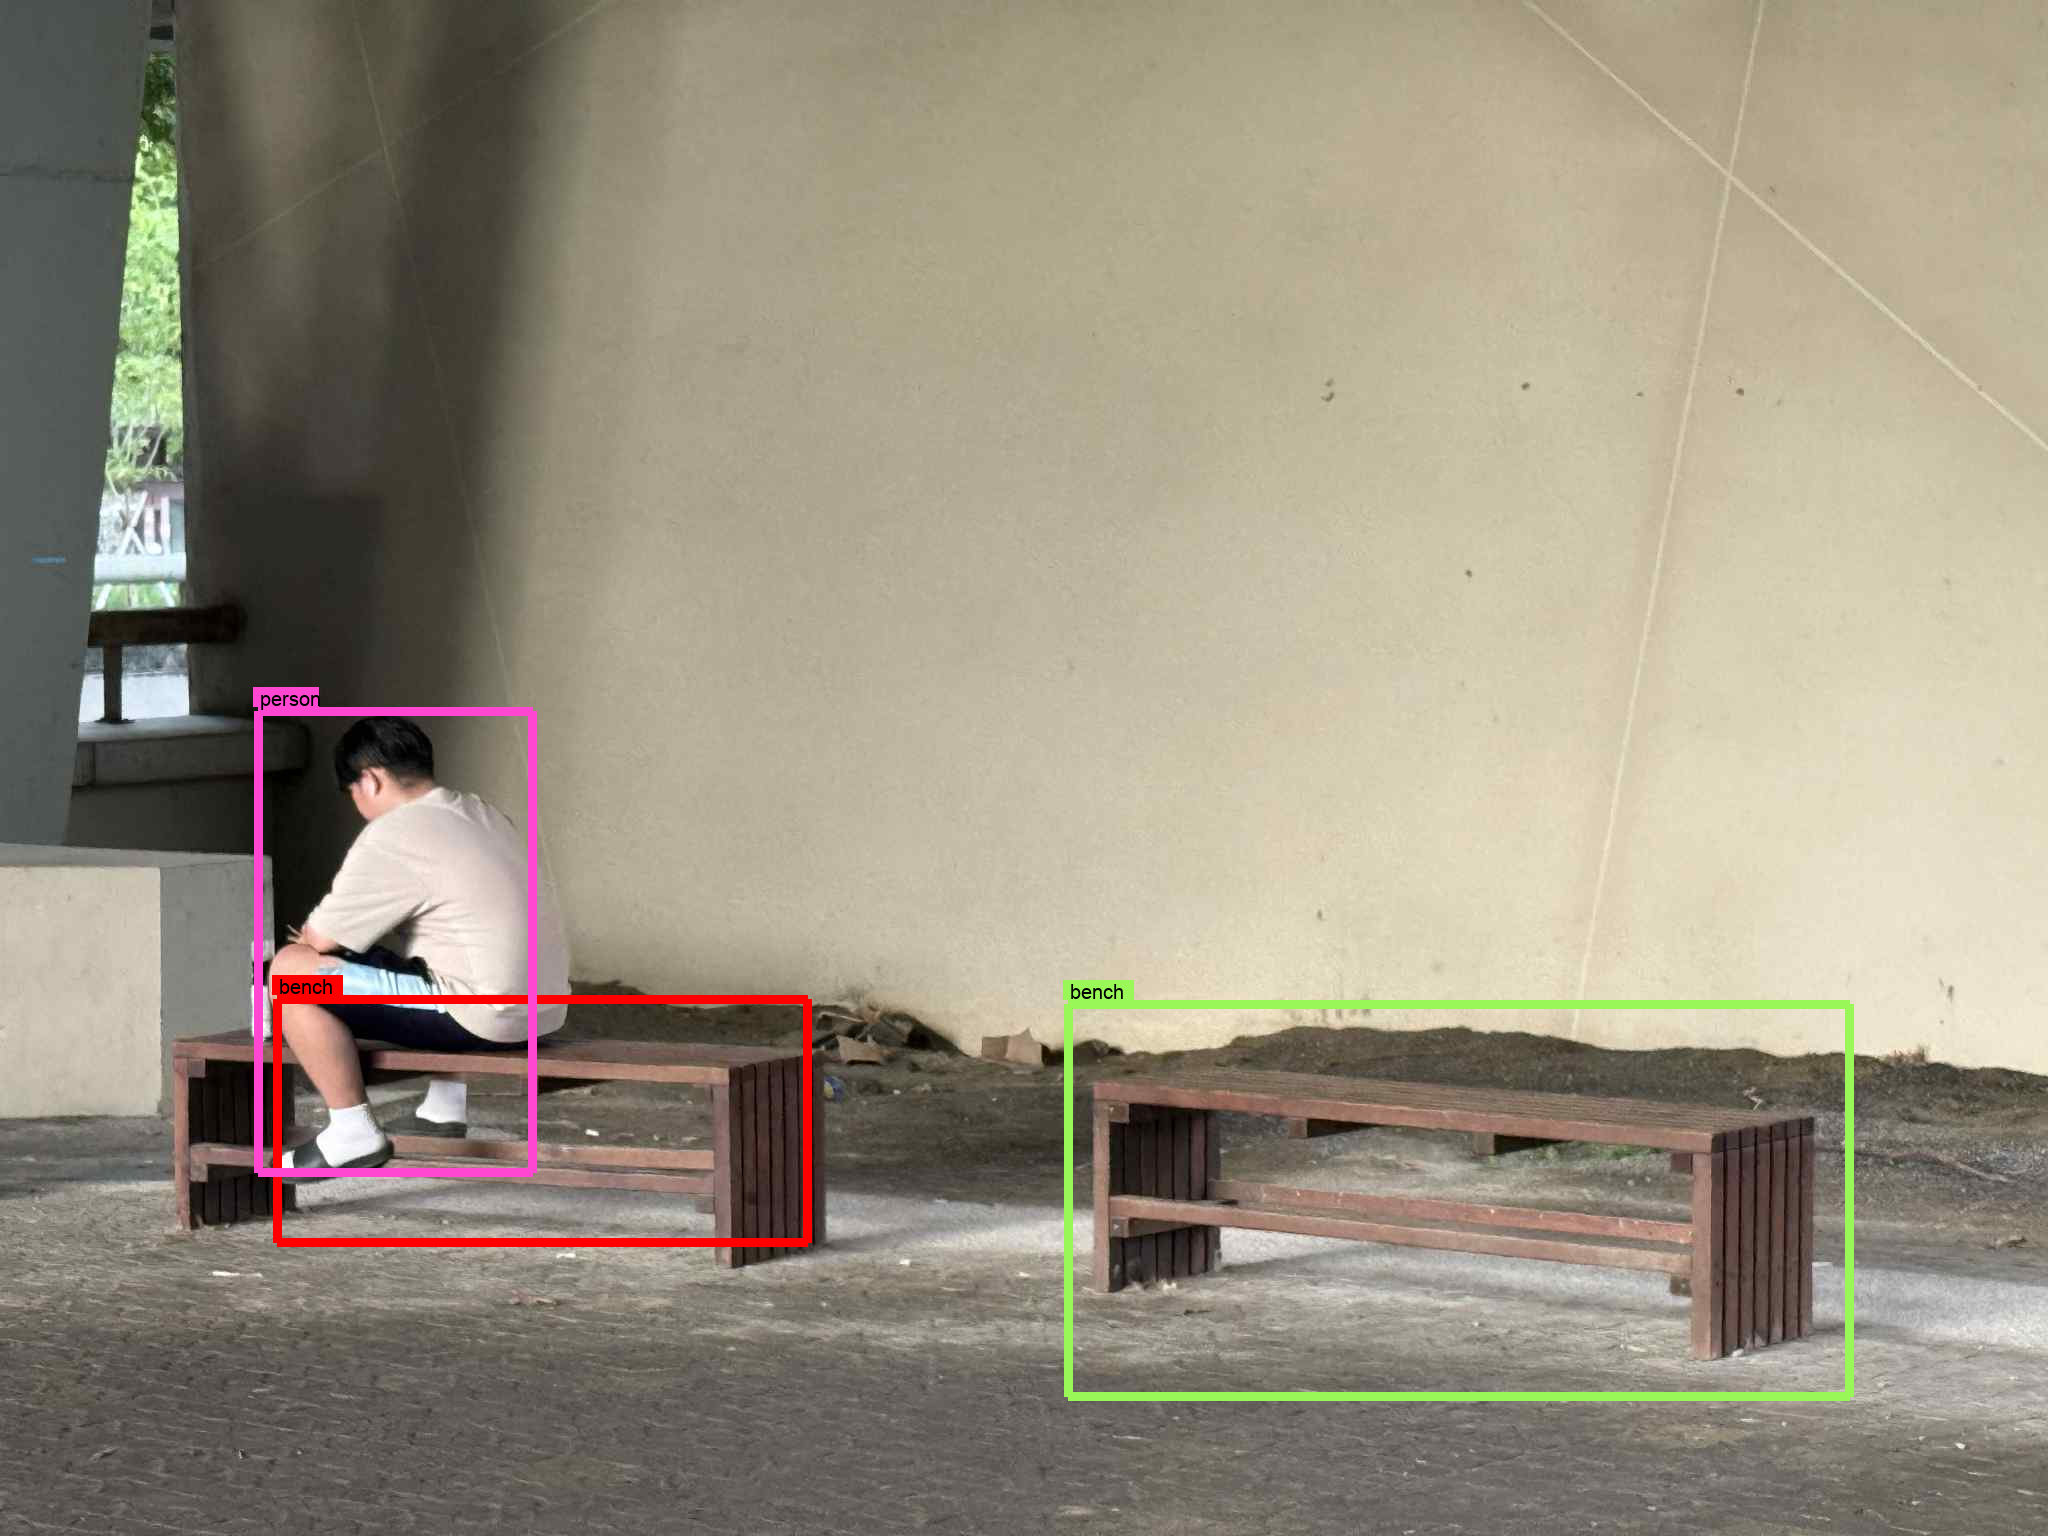

In [18]:
frame_in=load_image()
img_w =frame_in.size[0]
img_h =frame_in.size[1]

#frame_in_img = PIL_Image.fromarray(frame_in) 

img_out = frame_in
yolo_meminout(frame_in,img_w,img_h,img_out)
img_out 

In [37]:

##============================================
#			clean  up
#============================================
xlnk.xlnk_reset()